# Visualisation of the DynAstVO database
---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from packages.dataCleaner import cleanData

# Cleaning the data file

The raw file contains Optical, Spatial and Radar observations, which are written in the text file using different formats. We need to clean this file in order to work with the data. We split the file into 2 distinct files, suppressing every useless line of data (object header and the position of a satellite in the case of spatial observation)

In [2]:
INPUT_FILE = r'Data\OMC20200621.txt'
OPTICAL_SPACE_OUTPUT_FILE = r'Data\OpticalSpaceData.txt'
RADAR_OUTPUT_FILE = r'Data\RadarData.txt'

cleanData(INPUT_FILE, OPTICAL_SPACE_OUTPUT_FILE, RADAR_OUTPUT_FILE)

2571320it [00:14, 175677.60it/s]


# Reading the data

## Optical and Spatial data

Firstly, we give a name to every column (cf documentation), and we read the file, previously separated according to the type of observation.
We start with the optical and spatial observations together in the same Dataframe because they have the same format.

In [3]:

import time as t
start = t.time()
OScolnames = {'obs_type': 'category',
              'measure_type': 'category',
              'year': np.uint16,
              'month': np.uint8,
              'day': np.float64,
              'RA': np.float64,
              'DEC': np.float64,
              'obs_code': 'category',
              'RA_bias_correction': np.float32,
              'DEC_bias_correction': np.float32,
              'RA_weight': np.float64,
              'DEC_weight': np.float64,
              'acceptance': 'bool',
              'catalog': 'category',
              'mag': np.float64,
              'nbr_obs': np.float16,
              'random_number': np.float64,
              'RA_delta': np.float64,
              'DEC_delta': np.float64,
              'xhi': np.float64,
              'mag_acceptance': np.float16,
              'mag_delta': np.float64,
              'object_number': 'category'}
c = [2,2,5,3,10,17,17,4,8,8,11,11,2,2,6,4,4,8,8,8,2,6,9]
OSdata = pd.read_fwf(OPTICAL_SPACE_OUTPUT_FILE, header=None, names=list(OScolnames.keys()), dtype=OScolnames, widths=c, low_memory=True, usecols=['year', 'RA_weight', 'RA_delta', 'DEC_weight', 'DEC_delta', 'mag', 'catalog', 'obs_code', 'xhi', 'acceptance'])
stop = t.time()
print("time : ", stop-start)


time :  75.45038866996765


## Radar Data

We repeat this step for the Radar data, which uses a different format.

In [4]:
RadarColnames = {'obs_type': 'category',
                 'measure_type': 'category',
                 'year': np.uint16,
                 'month': np.uint8,
                 'day': np.float64,
                 'Distance/Velocity': np.float64,
                 'c': 'category',
                 'obs_code_tr': 'category',
                 'obs_code_rc': 'category',
                 'bias_correction': np.float32,
                 'precision': np.float64,
                 'acceptance': 'bool',
                 'RA_delta': np.float64,
                 'xhi': np.float64,
                 'object_number': 'category'}

Rdata = pd.read_fwf(RADAR_OUTPUT_FILE, header=None, names=list(RadarColnames.keys()), dtype=RadarColnames, low_memory=True, )

## Cleaning the catalog names

In [5]:
from packages.catalogCodes import catalog_codes
OSdata = OSdata.replace({'catalog':catalog_codes})
OSdata['catalog'] = OSdata['catalog'].astype('category')

In [6]:
N_CAT = 15
MOST_USED_CATALOGS = list(OSdata['catalog'].value_counts().head(N_CAT).index)
print(MOST_USED_CATALOGS)

['UCAC-4', 'USNO-B1.0', 'USNO-A2.0', 'UCAC-2', 'Gaia-DR2', 'UCAC-3', 'Gaia-DR1', '2MASS', 'PPMXL', 'USNO-SA2.0', 'SST-RC4', 'GSC', 'NOMAD', 'GSC-ACT', 'USNO-A1.0']


We add a new column named `delta_vect` which is the norm of RA_delta and the DEC_delta. We do the same for the weight.

We also remove the bad data

In [7]:
OSdata['delta_vect'] = np.sqrt(np.power(OSdata.RA_delta,2) + np.power(OSdata.DEC_delta,2))
OSdata['weight_vect'] = np.sqrt(np.power(OSdata.RA_weight,2) + np.power(OSdata.DEC_weight,2))
OSdata = OSdata.drop(OSdata[OSdata.xhi > 3].index)
OSdata = OSdata.drop(OSdata[OSdata.RA_delta > 20].index)
OSdata = OSdata.drop(OSdata[OSdata.DEC_delta > 20].index)
OSdata.dropna(subset=['RA_delta'], inplace=True)
OSdata.dropna(subset=['DEC_delta'], inplace=True)
OSdata.dropna(subset=['xhi'], inplace=True)

---
# Most important observatories

Some observatories are publishing a lot more data than others, and so are more reliable. Let's try to visualise which observatories are the most important by ploting the number of observations per observatory.

In [8]:
N_OBS = 20
BEST_OBS_LIST = list(OSdata['obs_code'].value_counts().head(N_OBS).index)

[Text(0, 0.5, 'Total number of observations'),
 Text(0.5, 0, 'Observatory code'),
 Text(0.5, 1.0, 'Number of observations by the 20 most active observatories')]

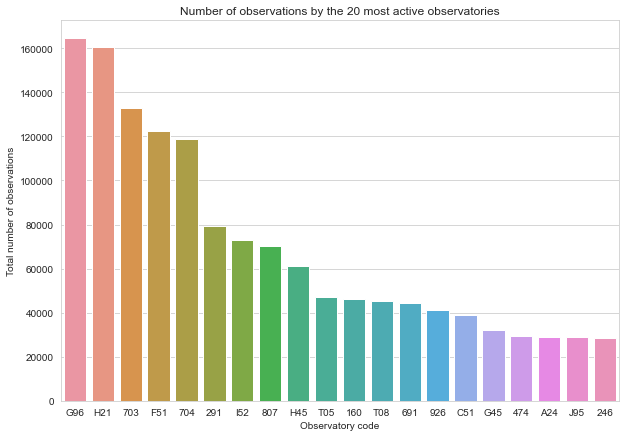

In [9]:
# plot the number of observations for the 20 bigest observatories
plt.figure(figsize=(10,7))
sns.set_style('whitegrid')
ax = sns.countplot(x='obs_code', data=OSdata, order=BEST_OBS_LIST)
ax.set(xlabel='Observatory code', ylabel='Total number of observations', title=f'Number of observations by the {N_OBS} most active observatories')

We can notice that the observatory G96 is the greatest contributor. This code corresponds to the Mt. Lemmon Survey observatory, a subsidiary of the Catalina Space Survey, ranked 3rd. The second greatest contributor, H21, is the Astronomical Research Observatory, Westfield. F51 corresponds to the PAN-STARSS sky survey in Hawaï The full list can be found here https://minorplanetcenter.net/iau/lists/ObsCodesF.html 

# Precision over time

With hardware improvements and new software, we can expect the precision of the observations to be better over time. We will verify this assumption for the best observatories.

## Study of the precision weight applied for the fitting process, for best observatories combined

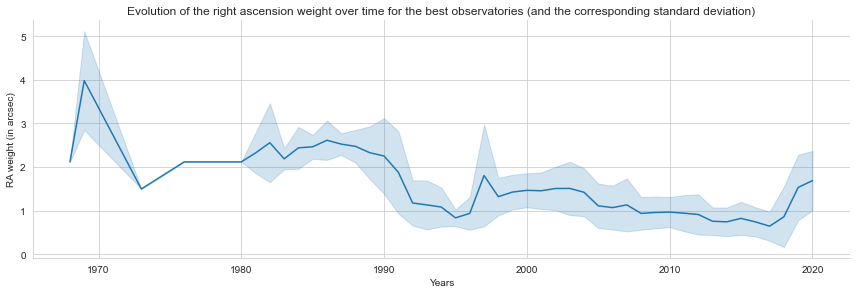

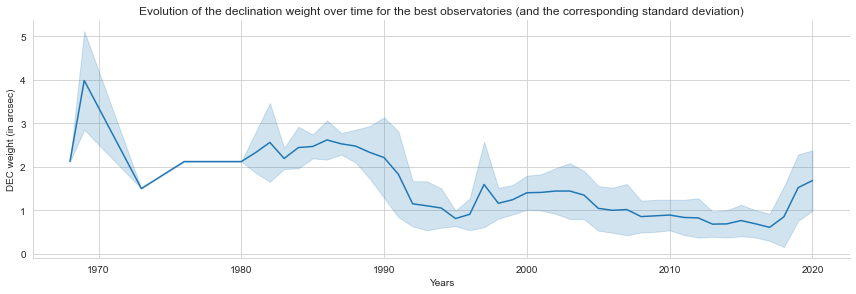

In [10]:
ax = sns.relplot(x='year', y='RA_weight', kind="line", ci="sd", data=OSdata[OSdata['obs_code'].isin(BEST_OBS_LIST)  & (OSdata['acceptance']==True)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='RA weight (in arcsec)', title='Evolution of the right ascension weight over time for the best observatories (and the corresponding standard deviation)')

ax = sns.relplot(x='year', y='DEC_weight', kind="line", ci="sd", data=OSdata[OSdata['obs_code'].isin(BEST_OBS_LIST) & (OSdata['acceptance']==True)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='DEC weight (in arcsec)', title='Evolution of the declination weight over time for the best observatories (and the corresponding standard deviation)')


## Evolution of the precision weight over time for the 5 best observatories 

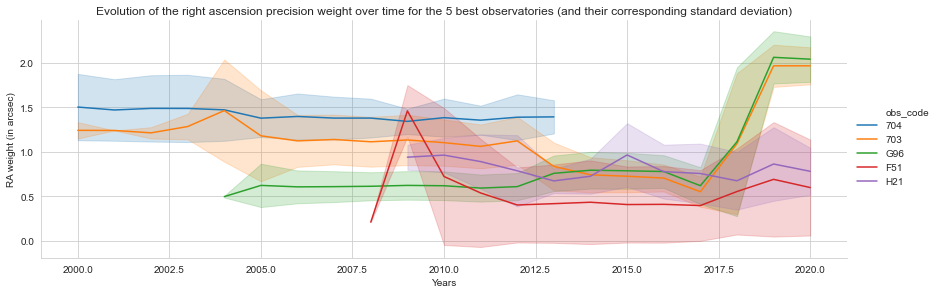

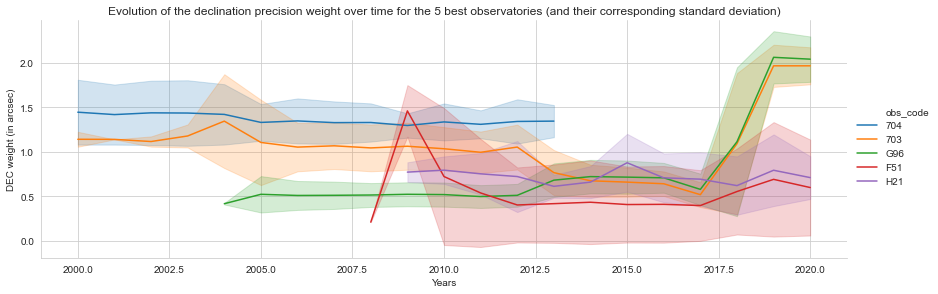

In [11]:
ax = sns.relplot(x='year', y='RA_weight', kind="line", ci="sd", hue='obs_code', 
                 data=OSdata[(OSdata['obs_code'].isin(BEST_OBS_LIST[:5])) & (OSdata['year'] >= 2000)  & (OSdata['acceptance']==True)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='RA weight (in arcsec)', title='Evolution of the right ascension precision weight over time for the 5 best observatories (and their corresponding standard deviation)')

ax = sns.relplot(x='year', y='DEC_weight', kind="line", ci="sd", hue='obs_code', 
                 data=OSdata[(OSdata['obs_code'].isin(BEST_OBS_LIST[:5])) & (OSdata['year'] >= 2000)  & (OSdata['acceptance']==True)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='DEC weight (in arcsec)', title='Evolution of the declination precision weight over time for the 5 best observatories (and their corresponding standard deviation)')


We can notice a strange augmentation of the precision weight since 2017, date of GAIA's entry into service. We expected a reduction of the precision weight for the observation made with GAIA's star catalogs (codes U and V), so this result may show a problem in the implementation of the fiting process. A theory is that the DynAstVO database, realized before GAIA results were published, does not take into account the new star catalogs introduced by GAIA, and so treats all the observations with the codes U and V like catalog-less observation, thus applying a bad precision weight.
However, GAIA's catalogs having the best precision currently available, this should be corrected to obtain a better overall precision.

Let's verify this assumption by comparing the average weight given to GAIA with the average weight given to every other star catalog as well as the non-referenced catalogs. We make sure to take into account only the observations accepted into the fitting process.

In [12]:
print("Mean of RA_weight for every catalog (2018-2020): ", OSdata['RA_weight'][(OSdata['catalog'] != 'Gaia-DR1') & (OSdata['catalog'] != 'Gaia-DR2') & (OSdata['year'] >= 2018)  & (OSdata['acceptance'] == True) & (OSdata['obs_code'].isin(BEST_OBS_LIST))].mean())
print("Mean of RA_weight for GAIA catalogs (2018-2020): ", OSdata['RA_weight'][(OSdata['catalog'] == 'Gaia-DR1') | (OSdata['catalog'] == 'Gaia-DR2') & (OSdata['acceptance'] == True) & (OSdata['obs_code'].isin(BEST_OBS_LIST))].mean())
print("Mean of RA_weight for non-referenced catalogs (2018-2020): ", OSdata['RA_weight'][(OSdata['catalog'].isnull()) & (OSdata['year'] >= 2018) & (OSdata['acceptance'] == True) & (OSdata['obs_code'].isin(BEST_OBS_LIST))].mean())

Mean of RA_weight for every catalog (2018-2020):  0.7134904440734557
Mean of RA_weight for GAIA catalogs (2018-2020):  1.2274227721861968
Mean of RA_weight for non-referenced catalogs (2018-2020):  2.048290598290598


This shows that the GAIA catalogs, supposedly the most precise, are in fact not being recognized for their value in the fitting process.

## Study of the RA_Delta and DEC_Delta in function of time

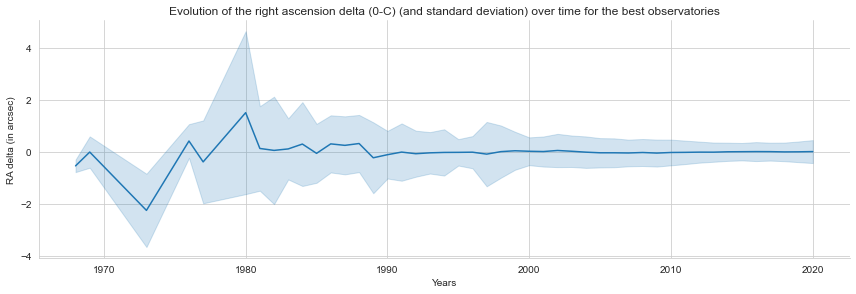

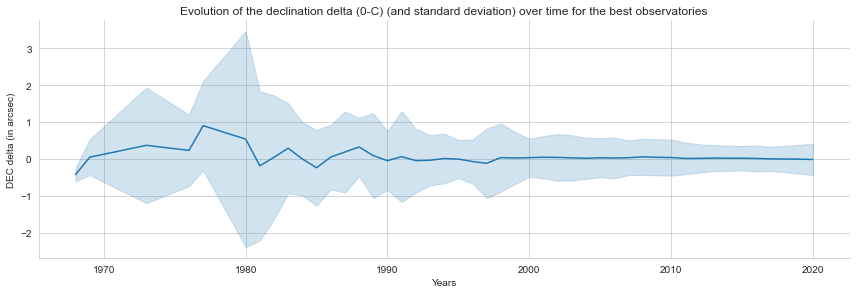

In [13]:
ax = sns.relplot(x='year', y='RA_delta', kind="line", ci="sd", data=OSdata[(OSdata['obs_code'].isin(BEST_OBS_LIST)) & (OSdata['acceptance']==True)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='RA delta (in arcsec)', title='Evolution of the right ascension delta (0-C) (and standard deviation) over time for the best observatories')

ax = sns.relplot(x='year', y='DEC_delta', kind="line", ci="sd", data=OSdata[OSdata['obs_code'].isin(BEST_OBS_LIST)  & (OSdata['acceptance']==True)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='DEC delta (in arcsec)', title='Evolution of the declination delta (0-C) (and standard deviation) over time for the best observatories')

As we can see on the graphs above, since 1990 and the widespread use of CCDs, the accuracy of measurements improved a lot. But we see few progress since 2000, with a delta of approx 0.2 arcsec. However, we can notice a slight increase since 2017, which i think is due to the "Gaia Bug" seen earlier. With the accuracy of Gaia star catalogs we should expect a reduction of the delta for both Right Ascension and Declination.

The Right Ascension precision seems to be more impacted than the Declination precision.

# Number of observations per year 

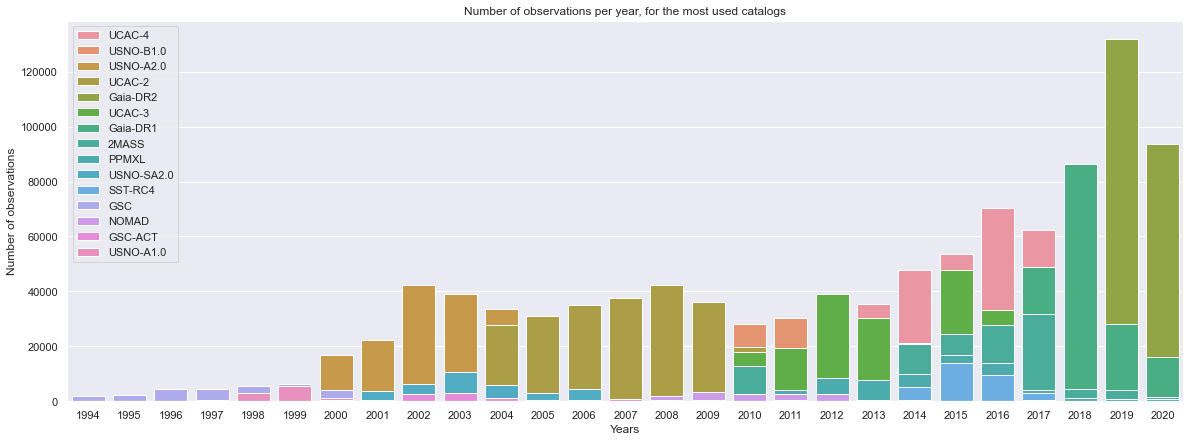

In [14]:
plt.figure(figsize=(20,7))
sns.set(rc={"axes.grid":True})
ax = sns.countplot(x='year', data=OSdata[(OSdata['year'] > 1993) & (OSdata['catalog'].isin(MOST_USED_CATALOGS))], hue='catalog', hue_order=MOST_USED_CATALOGS, dodge=False)
ax.set(xlabel='Years', ylabel='Number of observations', title='Number of observations per year, for the most used catalogs')
plt.legend(loc='upper left')

As we can see on the previous graph, the introduction of the GAIA star catalogs in 2017 for Gaia-DR1 and 2018 for Gaia-DR2 is very noticable. Those two catalogs became the norm due to their very high precison, with only a few observations associated with UCAC-3 which was the most used catalog in the 2010s. In 6 months, 2020 already gathered more observations than the full year of 2018.

The very high number of observations made with the Gaia catalogs should result in an increase in precision.

# Precision of the Star Catalogs

Here we compute the mean, median and standard deviation of the `delta_vect` data for each catalog.

In [15]:
stats = pd.DataFrame(index=MOST_USED_CATALOGS, columns=['mean', 'std', 'median', 'count'])
for catalog in MOST_USED_CATALOGS:
    mean = OSdata[(OSdata['catalog'] == catalog) & (OSdata['acceptance'] == 1)].delta_vect.mean()
    std = OSdata[(OSdata['catalog'] == catalog) & (OSdata['acceptance'] == 1)].delta_vect.std()
    median = OSdata[(OSdata['catalog'] == catalog) & (OSdata['acceptance'] == 1)].delta_vect.median()
    count = len(OSdata[(OSdata['catalog'] == catalog) & (OSdata['acceptance'] == 1)].index)
    stats.loc[catalog] = pd.Series({'mean': mean, 'std': std, 'median': median, 'count': count})
stats

mean       std    median   count
UCAC-4      0.451791   0.36323  0.349961  322055
USNO-B1.0   0.455628  0.398153  0.342615  321212
USNO-A2.0   0.632305  0.531288  0.492411  297751
UCAC-2      0.496065   0.41283  0.377805  289670
Gaia-DR2    0.482478  0.477865  0.353442  281163
UCAC-3      0.353871  0.289596  0.274447  265826
Gaia-DR1    0.286401  0.243991  0.210077  183972
2MASS       0.314383  0.353177  0.190436  143423
PPMXL       0.287322  0.271082  0.205387   69635
USNO-SA2.0  0.694679  0.617226   0.51765   41123
SST-RC4     0.380393  0.279632  0.314724   31922
GSC         0.757856  0.522784  0.640747   30124
NOMAD       0.432139  0.499593   0.29714   14875
GSC-ACT     0.656527   0.54305  0.502032   13558
USNO-A1.0   0.859892  0.681824  0.670293   11720

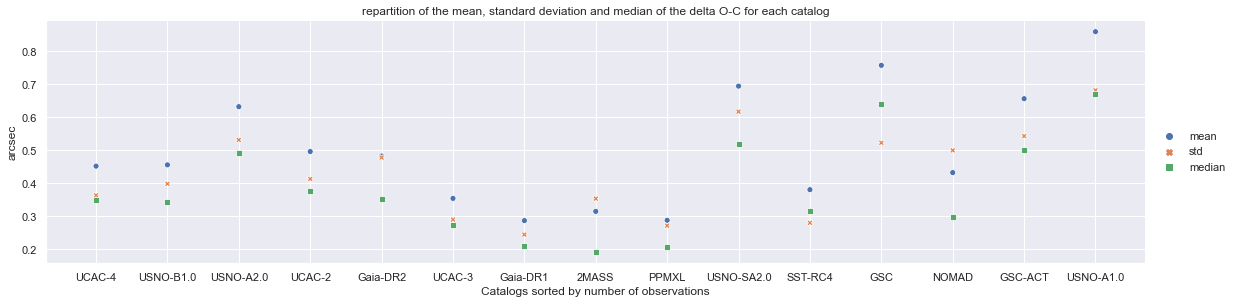

In [16]:
ax = sns.relplot(data=stats.drop(['count'], axis=1), height=4, aspect=4)
ax.set(xlabel='Catalogs sorted by number of observations', ylabel='arcsec',
       title='repartition of the mean, standard deviation and median of the delta O-C for each catalog')

Some of the old catalogs like PPMXL still have good statistics. The first GAIA catalog is very precise but the standard deviation is way too high. However Gaia-DR2 seams to be worse than most of the other catalogs. PPXML and SST-RC4 have contributed to 100k observations combined, which is very few, compared to other catalogs.

Strangely, UCAC-4 seams less precise than UCAC-3 despite being introduced later.

## Precision weight in function of the star catalog

In [17]:
weight_stats = pd.DataFrame(index=MOST_USED_CATALOGS, columns=['mean', 'std', 'median', 'count'])
for catalog in MOST_USED_CATALOGS:
    mean = OSdata[(OSdata['catalog'] == catalog) & (OSdata['acceptance'] == 1)].weight_vect.mean()
    std = OSdata[(OSdata['catalog'] == catalog) & (OSdata['acceptance'] == 1)].weight_vect.std()
    median = OSdata[(OSdata['catalog'] == catalog) & (OSdata['acceptance'] == 1)].weight_vect.median()
    count = len(OSdata[(OSdata['catalog'] == catalog) & (OSdata['acceptance'] == 1)].index)
    weight_stats.loc[catalog] = pd.Series({'mean': mean, 'std': std, 'median': median, 'count': count})
weight_stats

mean       std    median   count
UCAC-4       1.11017   0.86804  0.891964  322055
USNO-B1.0    1.30331  0.867013   1.11985  321212
USNO-A2.0    1.98762   1.05137   1.93073  297751
UCAC-2       1.10421  0.539625  0.997439  289670
Gaia-DR2     2.96593   1.18158   2.82843  281163
UCAC-3       1.17003   1.12149  0.891964  265826
Gaia-DR1    0.598599  0.254511  0.565685  183972
2MASS       0.765661  0.490544  0.519016  143423
PPMXL       0.665433  0.397487  0.612354   69635
USNO-SA2.0   2.08371   1.31336    1.6844   41123
SST-RC4       1.8009  0.329358   1.72534   31922
GSC          1.25147   0.50404   1.08972   30124
NOMAD        2.91774  0.890595   2.82843   14875
GSC-ACT      2.30352   1.83354   1.59812   13558
USNO-A1.0    1.83702  0.503467   1.74413   11720

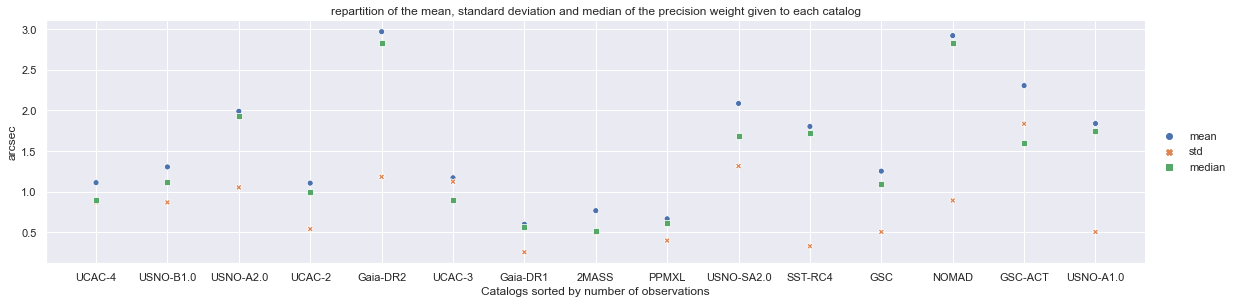

In [18]:
ax = sns.relplot(data=weight_stats.drop(['count'], axis=1), height=4, aspect=4)
ax.set(xlabel='Catalogs sorted by number of observations', ylabel='arcsec',
       title='repartition of the mean, standard deviation and median of the precision weight given to each catalog')

From this graph we can see  that the UCAC catalogs are fairly well rated. We can notice that Gaia-DR1 is one the best weighted catalogs, but Gaia-DR2 is the worst. This correlates with previous results.

## Xhi square

Xhi square is calculated as : ((O-C)/weight)^2

If it is too close to zero, the weightmay be too high. If it is too far to zero, the weight may be too low. This also varies with the delta (O-C) of the observations.

### By catalog

In [19]:
xhi_df = pd.DataFrame(index=MOST_USED_CATALOGS, columns=['xhi_2', 'std'])
for catalog in MOST_USED_CATALOGS:
    xhi_2 = np.power(OSdata[(OSdata['catalog'] == catalog) & (OSdata['acceptance'] == 1)].xhi, 2).mean()
    xhi_2_std = np.power(OSdata[(OSdata['obs_code'] == catalog) & (OSdata['acceptance'] == 1)].xhi, 2).std()
    xhi_df.loc[catalog] = pd.Series({'xhi_2': xhi_2, 'std': xhi_2_std})

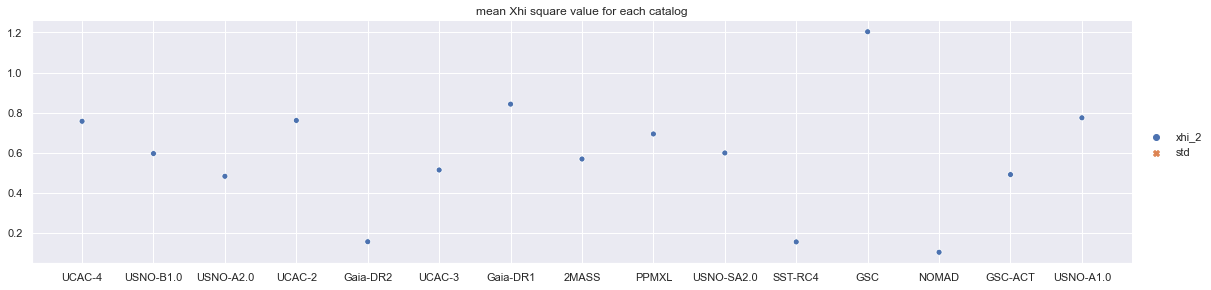

In [20]:
ax = sns.relplot(data=xhi_df, height=4, aspect=4)
ax.set(title="mean Xhi square value for each catalog")


Here we can notice that Gaia-DR2 has a xhi square value very close to zero. We noticed earlier that the weigth given to Gaia-DR2 is too high, thus modifying this xhi square value.
The objective is to have rougly the same xhi square values for every catalog.

The standard deviation is constant for each catalog.

### By observatory

In [21]:
xhi_df = pd.DataFrame(index=BEST_OBS_LIST, columns=['xhi', 'std'])
for obs in BEST_OBS_LIST:
    xhi_2 = np.power(OSdata[(OSdata['obs_code'] == obs) & (OSdata['acceptance'] == 1)].xhi, 2).mean()
    xhi_2_std = np.power(OSdata[(OSdata['obs_code'] == obs) & (OSdata['acceptance'] == 1)].xhi, 2).std()
    xhi_df.loc[obs] = pd.Series({'xhi': xhi_2, 'std': xhi_2_std})

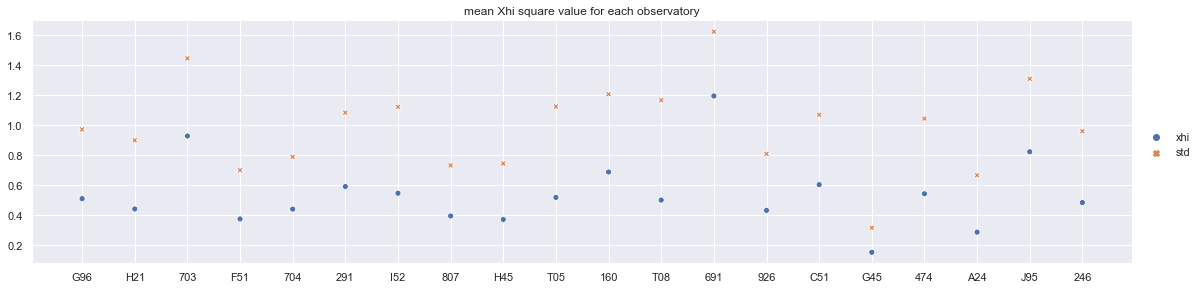

In [22]:
ax = sns.relplot(data=xhi_df, height=4, aspect=4)
ax.set(title="mean Xhi square value for each observatory")

# Influence of Magnitude on precision of observations.

## By observatory 

In [23]:
sample_obs = OSdata[(OSdata['delta_vect']<=4) & (OSdata.obs_code.isin(BEST_OBS_LIST[:6]))].sample(10000)
sample_obs.mag = sample_obs.mag.replace(99.99, np.nan)


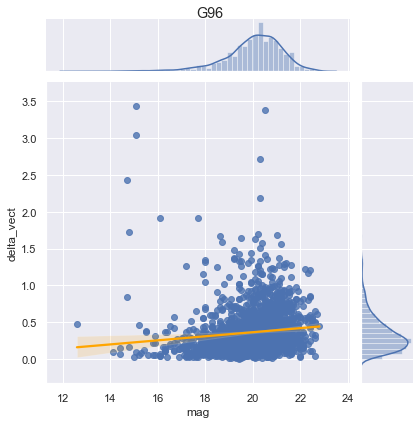

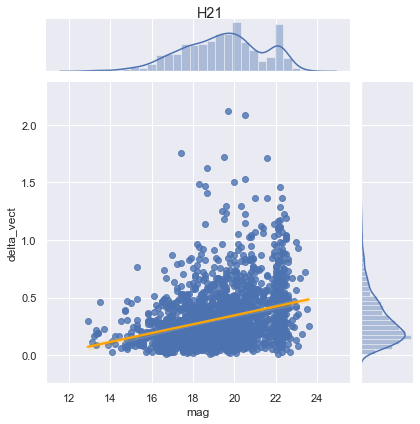

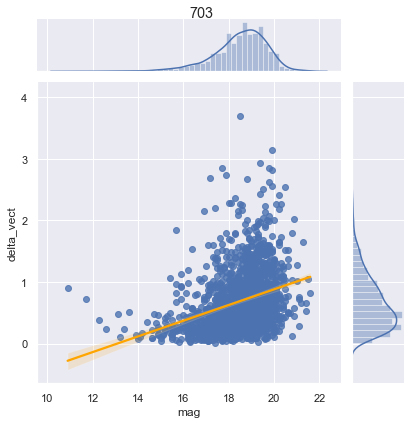

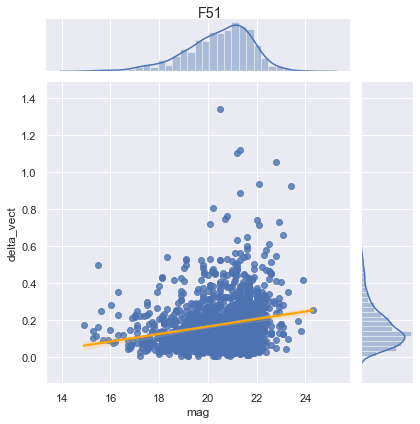

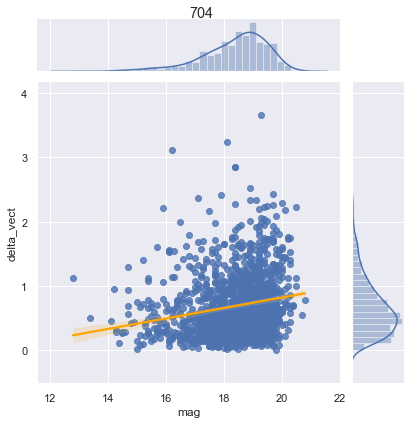

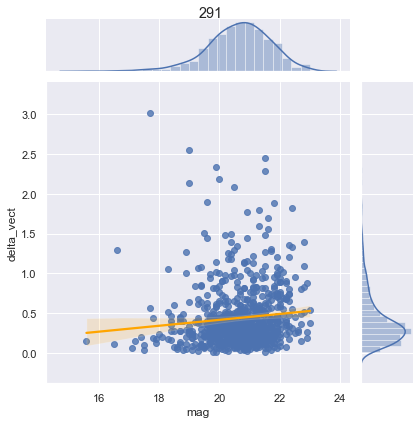

In [24]:
for obs in BEST_OBS_LIST[:6]:
    ax = sns.jointplot(x='mag', y='delta_vect', data=sample_obs[sample_obs.obs_code==obs], kind='reg', line_kws={'color':'orange'})
    ax.fig.suptitle(obs)
    ax.fig.subplots_adjust(top=0.95) 

We can notice a slight correlation between the apparent magnitude of the object and the precision. The dimmer the object, the less precise the observation.

## By catalog

In [25]:
sample_cat = OSdata[(OSdata['delta_vect']<=4) & (OSdata.catalog.isin(MOST_USED_CATALOGS[:6])) & (OSdata.mag >= 14)].sample(10000)
sample_cat.mag = sample_cat.mag.replace(99.99, np.nan)

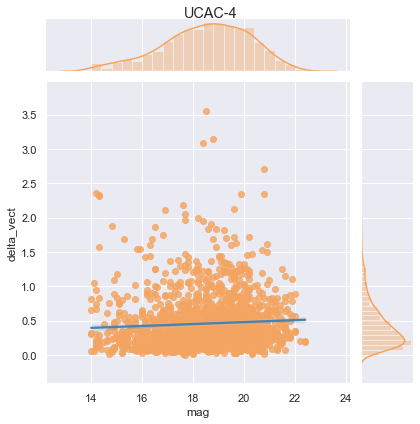

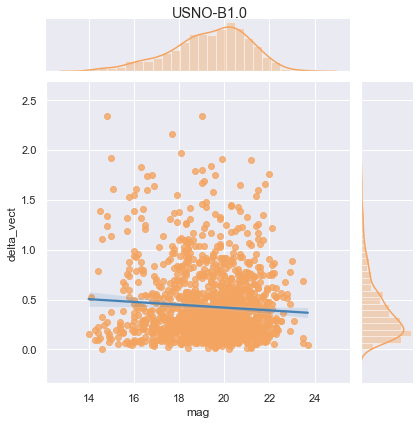

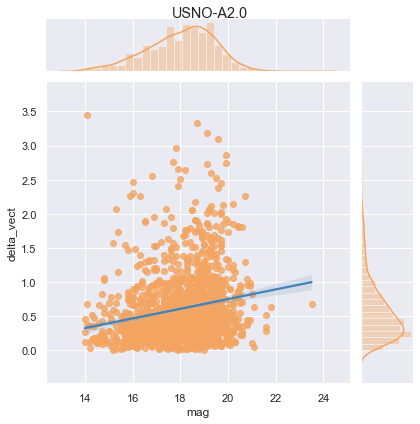

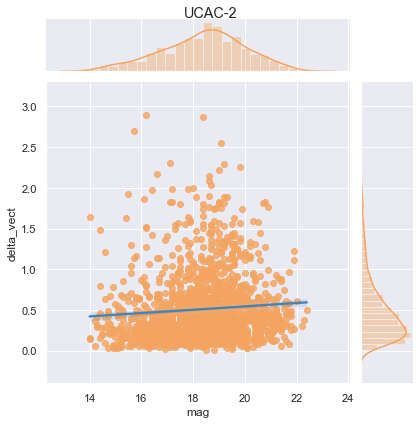

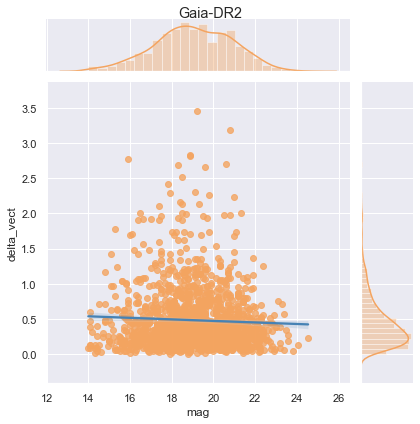

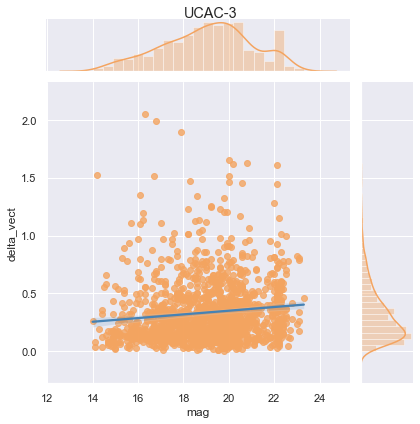

In [26]:
for cat in MOST_USED_CATALOGS[:6]:
    ax = sns.jointplot(x='mag', y='delta_vect', data=sample_cat[sample_cat.catalog==cat], kind='reg', color='sandybrown', line_kws={'color':'steelblue'})
    ax.fig.suptitle(cat)
    ax.fig.subplots_adjust(top=0.95)

There is no universal relation between the apparent magnitude and the precision of the observation. However, some catalogs like USNO-A2 have a correlation. On the other hand, GAIA-DR2 seems to have an inverse proportional correlation. Same for USNO-B1.0
# Catalog repartition per observatory

The goal of this section is to find which catalogs are used by the biggest observatories.

In [27]:
l_cat = []
for cat in MOST_USED_CATALOGS:
    l_obs = []
    for obs in BEST_OBS_LIST:
        l_obs.append(len(OSdata[(OSdata['obs_code']==obs) & (OSdata['catalog']==cat)]))
    l_cat.append(l_obs)
l_cat = np.array(l_cat)


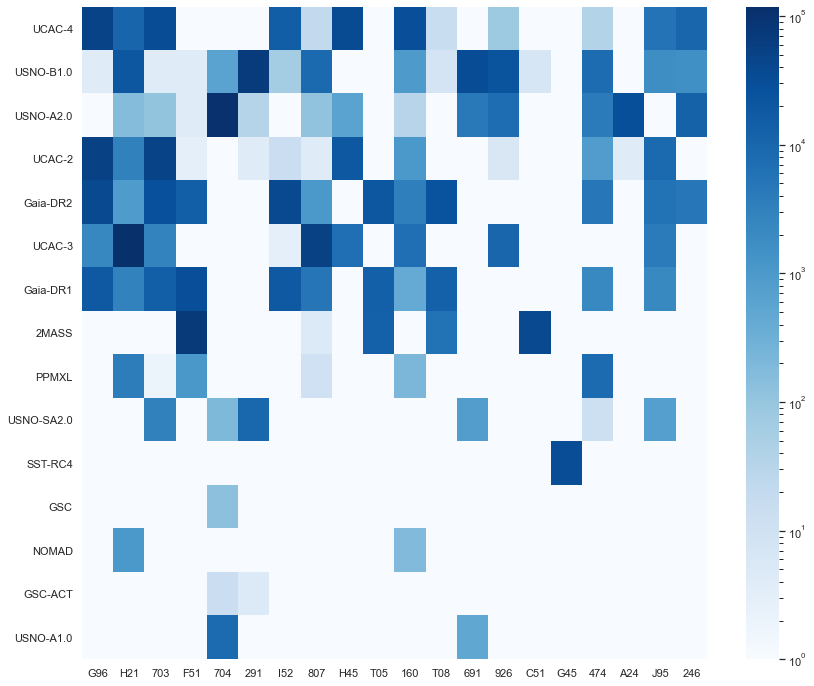

In [28]:
plt.figure(figsize=(14,12))
ax = sns.heatmap(np.maximum(l_cat, 1), annot=False, cmap='Blues', norm=LogNorm(), yticklabels=MOST_USED_CATALOGS, xticklabels=BEST_OBS_LIST)